# Credit Card Fraud Detection

### Import Libraries

In [2]:
!pip install xgboost
!pip install imbalanced-learn

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 7.2 MB/s eta 0:00:10
    --------------------------------------- 1.6/72.0 MB 4.0 MB/s eta 0:00:18
   - -------------------------------------- 2.4/72.0 MB 3.9 MB/s eta 0:00:18
   - -------------------------------------- 3.1/72.0 MB 3.8 MB/s eta 0:00:18
   -- ------------------------------------- 3.9/72.0 MB 3.7 MB/s eta 0:00:19
   -- ------------------------------------- 4.7/72.0 MB 3.8 MB/s eta 0:00:18
   --- ------------------------------------ 5.5/72.0 MB 3.9 MB/s eta 0:00:18
   --- ------------------------------------ 6.0/72.0 MB 3.6 MB/s eta 0:00:19
   --- ------------------------------------ 6.8/72.0 MB 3.6 MB/s eta 0:00:18
   ---- ----------------------------------- 7.3/72.0 MB 3.5 MB/s eta 0:00:19
   ---- ----------------------------------- 7.6/72.0 MB 3.5 MB/s eta 0:00:19
   ---- ----------------------------------- 8.4/72.0 MB 3.4 MB/s eta 0:00:19
   ---


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
import joblib

### Load the Dataset

In [4]:
# Load dataset (make sure creditcard.csv is in the same folder)
df = pd.read_csv('creditcard.csv')

# Basic info
print(df.shape)
print(df.head())
print(df['Class'].value_counts())


(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

### Quick Exploration

In [5]:
fraud_count = df['Class'].sum()
total = len(df)
print(f"Fraudulent transactions: {fraud_count}/{total} ({fraud_count/total:.6f} fraction)")

# Check for missing values
print(df.isnull().sum().sum(), "missing values in dataset.")


Fraudulent transactions: 492/284807 (0.001727 fraction)
0 missing values in dataset.


### Feature Preparation

In [6]:
X = df.drop('Class', axis=1)
y = df['Class']

# Drop Time column (not useful)
if 'Time' in X.columns:
    X = X.drop('Time', axis=1)

# Scale Amount
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)


Train set: (227845, 29) Test set: (56962, 29)


### Handle Class Imbalance (SMOTE)

In [8]:
import imblearn
print(imblearn.__version__)

0.13.0


In [9]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE, class distribution:", np.bincount(y_train_res))


After SMOTE, class distribution: [227451 227451]


### Logistic Regression

In [10]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_res, y_train_res)

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))


Logistic Regression Report:
              precision    recall  f1-score   support

           0     0.9999    0.9735    0.9865     56864
           1     0.0563    0.9184    0.1061        98

    accuracy                         0.9734     56962
   macro avg     0.5281    0.9459    0.5463     56962
weighted avg     0.9982    0.9734    0.9850     56962

ROC AUC: 0.970028112187475


### Random Forest

In [11]:
rf = RandomForestClassifier(
    n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


Random Forest Report:
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8602    0.8163    0.8377        98

    accuracy                         0.9995     56962
   macro avg     0.9299    0.9080    0.9187     56962
weighted avg     0.9994    0.9995    0.9994     56962

ROC AUC: 0.9718193534448107


### XGBoost Model

In [12]:
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 6,
    'scale_pos_weight': (len(y_train_res) - y_train_res.sum()) / y_train_res.sum(),
    'seed': 42,
    'verbosity': 0
}

bst = xgb.train(params, dtrain, num_boost_round=200)
y_proba_xgb = bst.predict(dtest)
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


XGBoost Report:
              precision    recall  f1-score   support

           0     0.9998    0.9988    0.9993     56864
           1     0.5629    0.8673    0.6827        98

    accuracy                         0.9986     56962
   macro avg     0.7813    0.9331    0.8410     56962
weighted avg     0.9990    0.9986    0.9988     56962

ROC AUC: 0.97799368058985


### Precision–Recall Curve

Precision–Recall AUC: 0.8573339882325374


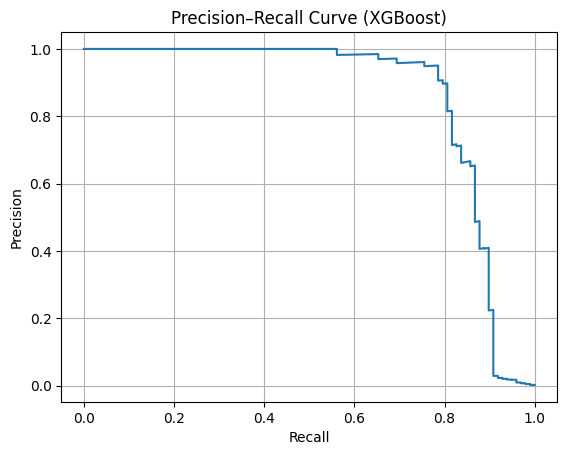

In [13]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)
pr_auc = auc(recall, precision)
print("Precision–Recall AUC:", pr_auc)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (XGBoost)")
plt.grid(True)
plt.show()

### Save Model and Scaler

In [14]:
bst.save_model('xgb_credit_fraud.model')
joblib.dump(scaler, 'scaler_amount.pkl')
print("Model and scaler saved successfully.")

Model and scaler saved successfully.


### Predict New Transactions

In [16]:
def predict_transaction(model_path, transaction_df):
    # Load saved scaler and model
    sc = joblib.load('scaler_amount.pkl')
    if 'Amount' in transaction_df.columns:
        transaction_df['Amount'] = sc.transform(transaction_df[['Amount']])
    dm = xgb.DMatrix(transaction_df)
    booster = xgb.Booster()
    booster.load_model(model_path)
    return booster.predict(dm)

# Example usage:
sample = X_test.iloc[:5].copy()
predictions = predict_transaction('xgb_credit_fraud.model', sample)
print(predictions)


[1.5178516e-05 4.7768917e-06 8.7843637e-06 4.4110490e-07 1.8495378e-04]
